# ResNet-18
Credit to: [Using ResNet for MNIST in PyTorch 1.7](https://zablo.net/blog/post/pytorch-resnet-mnist-jupyter-notebook-2021/)

##Python Setup

In [1]:
!git clone https://github.com/HanziJiang/CapsNet-ResNet-Performance-Analysis.git

Cloning into 'CapsNet-ResNet-Performance-Analysis'...
remote: Enumerating objects: 216, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 216 (delta 31), reused 67 (delta 31), pack-reused 149
Receiving objects: 100% (216/216), 971.64 MiB | 32.47 MiB/s, done.
Resolving deltas: 100% (105/105), done.


In [2]:
!pip install torch torchvision
!pip install matplotlib
!pip install import-ipynb
!pip install pytorch_extras
!pip install pytorch_lightning

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp37-none-any.whl size=2976 sha256=8a4f8ae97276588f86b60d71318cb8bd4727e68ac5da7fad12666380070462f2
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb
  Created wheel for pytorch-extras: filename=pytorch_extras-0.1.3-cp37-none-any.whl size=2833 sha256=3c0dd318071529364abdcc23c17e7337633ab70a31441708a3d7aec475610fad
  Stored in directory: /root/.cache/pip/wheels/5b/7c/5a/f27d4088adfe722cb280d523a1ed9eeb33be11b8d3a653292a
Successfully built pytorch-extras
     |████████████████████████████████| 849kB 4.6MB/s 
     |████████████████████████████████| 829kB 9.5MB/s 
     |████████████████████████████████| 276kB 19.9MB/s 
     |████████████████████████████████| 276kB 16.3MB/s 
     |████████████████████████████████| 112kB 21.7MB/s 
     |████████████████████████████████| 1.3MB 17.8MB/s 
     |████████████████████████████████| 143kB 34.0MB/s 
  

In [3]:
%cd "CapsNet-ResNet-Performance-Analysis"

/content/CapsNet-ResNet-Performance-Analysis


In [4]:
from torchvision.models import resnet18
from torch import nn
import torch
import numpy as np
import import_ipynb
import load_DrawData_with_transform as loader
import pytorch_lightning as pl
from pytorch_lightning.core.decorators import auto_move_data
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

importing Jupyter notebook from load_DrawData_with_transform.ipynb
     |████████████████████████████████| 71kB 3.6MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.2.0-cp37-none-any.whl size=89548 sha256=d6f6baa57035c7c04d6037d2a2b1682c3da18050c6e18ad728406ca2553e47b1
  Stored in directory: /root/.cache/pip/wheels/40/76/48/f1effadceea83b32e7d957dd0f92db4db8b537d7b72b4ef374
Successfully built cairocffi
batch_size: 8
total training samples: 15000
total validatoin samples: 5000
total test samples: 5000
Copying gs://quickdraw_dataset/full/simplified/triangle.ndjson...
- [1/1 files][ 30.5 MiB/ 30.5 MiB] 100% Done                                    
Operation completed over 1 objects/30.5 MiB.                                     
Copying gs://quickdraw_dataset/full/simplified/square.ndjson...
- [1/1 files][ 32.0 MiB/ 32.0 MiB] 100% Done                                    
Operation completed over 1 objects/32.0 MiB.                                     
Copying gs://quickdraw_dataset

## Model

In [ ]:
class ResNet(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = resnet18()
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.loss = nn.CrossEntropyLoss()

    @auto_move_data
    def forward(self, x):
        x = torch.unsqueeze(x, 1)
        return self.model(x.float())

    def training_step(self, batch, batch_no):
        # implement single training step
        x, y = batch
        logits = self(x)
        y = y.max(1, keepdim=False)[1].type(torch.LongTensor)
        loss = self.loss(logits, y)
        return loss

    def configure_optimizers(self):
        return torch.optim.RMSprop(self.parameters(), lr=0.005)

## Train

In [ ]:
train_loader, valid_loader, test_loader = loader.train_loader, loader.valid_loader, loader.test_loader

model = ResNet()
model = model.cuda()

trainer = pl.Trainer(
    max_epochs=1,
    progress_bar_refresh_rate=30 # set to >= 20 if running in Google Colab
)

#model
trainer.fit(model, train_loader)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)

  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 11.7 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.733    Total estimated model params size (MB)


1

In [ ]:
trainer.save_checkpoint("resnet18.pt")

In [ ]:
def get_prediction(x, model: pl.LightningModule):
    model.freeze() # prepares model for predicting
    probabilities = torch.softmax(model(x), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities

In [ ]:
inference_model = ResNet.load_from_checkpoint("resnet18.pt", map_location="cuda")

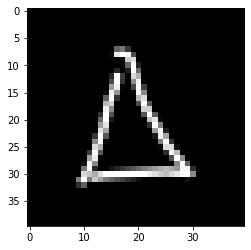

In [ ]:
for i, (data,target) in enumerate(test_loader):
    for j in range(6):
        plt.imshow(data[j], cmap = "gray")
    break

In [ ]:
true_y, pred_y = [], []
for batch in tqdm(iter(test_loader), total=len(test_loader)):
  x, y = batch
  y = y.max(1, keepdim=False)[1].type(torch.LongTensor)
  true_y.extend(y)
  preds, probs = get_prediction(x, inference_model)
  pred_y.extend(preds.cpu())

In [ ]:
# Test accuracy
np.mean(np.equal(true_y, pred_y))

0.9752

In [ ]:
true_y, pred_y = [], []
for batch in tqdm(iter(valid_loader), total=len(valid_loader)):
    x, y = batch
    y = y.max(1, keepdim=False)[1].type(torch.LongTensor)
    true_y.extend(y)
    preds, probs = get_prediction(x, inference_model)
    pred_y.extend(preds.cpu())

In [ ]:
# Validation accuracy
np.mean(np.equal(true_y, pred_y))

0.979